
# Diabetes Readmission Predictions using DSX and Python.

This notebook uses the dataset found at the University of California at Irvine, Machine Learning Repository.

https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008

Copyright (c) 2016 - 2017 IBM Corp.

Author: Steven C. Geringer

Summary: This notebook builds a predictive model for predicting hospital readmissions within 30 days of discharge.

Feedback is welcome and appreciated.


# Imports 

In [37]:
%matplotlib inline

# Imports from the base Python Libraries

import time
import requests
from collections import Counter
from StringIO import StringIO

# Imports for the Dataframe handling libraries

import pandas as pd
import numpy as np

# Selective Imports for the Machine Learning Library

from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

In [38]:
from bokeh.io import output_notebook
output_notebook()

from bokeh.charts import Bar,  show, Scatter
from bokeh.charts import defaults
defaults.width = 800
defaults.height = 400

Loading BokehJS ...

# Load the data into a Pandas DataFrame

In [39]:
# Print the Start time
print 'Start: ',time.asctime()

def load_csv_to_df(file_url):
    return pd.read_csv(StringIO((requests.get(file_url)).text), sep=",")



train_url = 'https://ibm.box.com/shared/static/4ix1ioo1cuy8aocz8koq46v084ad3b1m.csv'
test_url = ''
    
# Here we read the both URLs into DataFrame objects.  Note we will only use df_train in this notebook.   
# By the way, the CSV file includes the Column Header names in the first row and Pandas handles these properly.
# Also, data types will be inferred as best as possible.  (Pandas allows columns to be mixed data types, these column will be typed as 'object')
    
df_train = load_csv_to_df(train_url)
#df_test = load_csv_to_df(test_url)

# print the shape of the dataframes.  (Number of Rows, Number of Columns)

print np.shape(df_train)
#print np.shape(df_test)

# print the end time to see how long the load took

print 'End: ',time.asctime()

Start:  Mon Nov 13 16:12:10 2017
(101766, 50)
End:  Mon Nov 13 16:12:15 2017




# Let's take a look at the raw data:

In [40]:
df_train.head(10)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,>30
6,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,...,No,No,No,No,No,No,No,No,Yes,>30
8,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [41]:
(df_train[df_train['readmitted']=='<30']).head(10)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
11,36900,77391171,AfricanAmerican,Male,[60-70),?,2,1,4,7,...,No,Steady,No,No,No,No,No,Ch,Yes,<30
12,40926,85504905,Caucasian,Female,[40-50),?,1,3,7,7,...,No,Down,No,No,No,No,No,Ch,Yes,<30
16,77076,92519352,AfricanAmerican,Male,[50-60),?,1,1,7,4,...,No,Steady,No,No,No,No,No,Ch,Yes,<30
46,486156,86240259,Caucasian,Female,[70-80),?,3,5,4,9,...,No,Down,No,No,No,No,No,Ch,Yes,<30
50,550098,21820806,AfricanAmerican,Male,[50-60),?,2,1,2,4,...,No,No,No,No,No,No,No,No,No,<30
68,796152,23043240,Caucasian,Female,[50-60),?,2,1,4,2,...,No,Steady,No,No,No,No,No,No,Yes,<30
70,870294,95075649,Caucasian,Female,[70-80),?,1,6,7,7,...,No,No,No,No,No,No,No,No,No,<30
77,1050294,100113975,Caucasian,Female,[60-70),?,3,3,1,3,...,No,Up,No,No,No,No,No,Ch,Yes,<30
114,1810752,6915888,Caucasian,Male,[70-80),?,1,3,7,14,...,No,Up,No,No,No,No,No,Ch,Yes,<30
116,1881372,3115566,Caucasian,Male,[60-70),?,1,2,7,4,...,No,Steady,No,No,No,No,No,No,Yes,<30


# Show all the columns and which columns have missing data 



In [43]:
# Loop through the column names in the df_train dataframe and count how many cells for each column are found to be null 

print "Missing values by column"
for col in df_train.columns:
    print col, len(df_train[pd.isnull(df_train[col])])

Missing values by column
encounter_id 0
patient_nbr 0
race 0
gender 0
age 0
weight 0
admission_type_id 0
discharge_disposition_id 0
admission_source_id 0
time_in_hospital 0
payer_code 0
medical_specialty 0
num_lab_procedures 0
num_procedures 0
num_medications 0
number_outpatient 0
number_emergency 0
number_inpatient 0
diag_1 0
diag_2 0
diag_3 0
number_diagnoses 0
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
examide 0
citoglipton 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0


# Handle Missing Values

In [44]:
#Not needed for this dataset

#df_train.fillna('x', inplace=True)
#df_test.fillna('x', inplace=True)

# Change from 3 class problem to 2 class problem

1. Readmitted < 30 Days
1. Readmitted > 30 Days
1. Not Readmitted

## Note This change only is effective in RAM.  it does not change the DB. 


Set readmitted to 1/0

In [45]:
df_train['readmitted'] = df_train['readmitted'].apply( lambda x: 1 if x == '<30' else 0)

## This is highly imbalanced data, that is, many more not readmitted than readmitted.

Depending on choice of algorithm and other aspects of the dataset, somtimes it helps to rebalance the dataset. 

In [46]:
# Downsample the df_train to balance readmitted 1/0.  

DOWNSAMPLE = 1  # need to turn on if using algos which are not robust to unbalanced data (most algos)

if DOWNSAMPLE == 1:
    
    df_positives = (df_train[df_train['readmitted'] == 1]).copy()
    df_negatives = (df_train[df_train['readmitted'] == 0]).sample(len(df_positives), axis=0)
    df_train = pd.concat((df_positives, df_negatives), axis=0)
    print np.shape(df_train)

    


(22714, 50)


# Remove Columns which are unique to each patient (will have little predictive value)




In [47]:

# Hard code the ones we know we want to drop.  Then to easily remove these from the list of all columns, 
# get the columns from the DataFrame, convert both lists to sets (for easy subtraction), convert back to a list as keep_cols. 
# This has one slightly unwanted side effect, that is it re-orders the columns.  This is a side effect of converting to set.


print 'Before: ',df_train.columns.values
drop_cols = ['encounter_id', 'patient_nbr', 'weight',  ]
keep_cols = list(set(df_train.columns) - set(drop_cols))
#print keep_cols

df_train = df_train[keep_cols]
print 'After: ',df_train.columns.values

Before:  ['encounter_id' 'patient_nbr' 'race' 'gender' 'age' 'weight'
 'admission_type_id' 'discharge_disposition_id' 'admission_source_id'
 'time_in_hospital' 'payer_code' 'medical_specialty' 'num_lab_procedures'
 'num_procedures' 'num_medications' 'number_outpatient' 'number_emergency'
 'number_inpatient' 'diag_1' 'diag_2' 'diag_3' 'number_diagnoses'
 'max_glu_serum' 'A1Cresult' 'metformin' 'repaglinide' 'nateglinide'
 'chlorpropamide' 'glimepiride' 'acetohexamide' 'glipizide' 'glyburide'
 'tolbutamide' 'pioglitazone' 'rosiglitazone' 'acarbose' 'miglitol'
 'troglitazone' 'tolazamide' 'examide' 'citoglipton' 'insulin'
 'glyburide-metformin' 'glipizide-metformin' 'glimepiride-pioglitazone'
 'metformin-rosiglitazone' 'metformin-pioglitazone' 'change' 'diabetesMed'
 'readmitted']
After:  ['chlorpropamide' 'repaglinide' 'payer_code' 'number_diagnoses'
 'num_medications' 'readmitted' 'rosiglitazone' 'miglitol' 'glipizide'
 'discharge_disposition_id' 'citoglipton' 'admission_source_id'
 'me

## Let's take another look at the data to see where we are

In [48]:
df_train.head()

,chlorpropamide,repaglinide,payer_code,number_diagnoses,num_medications,readmitted,rosiglitazone,miglitol,glipizide,discharge_disposition_id,...,nateglinide,tolazamide,race,glipizide-metformin,insulin,gender,num_procedures,diag_2,diag_3,admission_type_id
11,No,No,?,7,11,1,No,No,No,1,...,No,No,AfricanAmerican,No,Steady,Male,0,288,197,2
12,No,Up,?,8,15,1,No,No,No,3,...,No,No,Caucasian,No,Down,Female,0,250.43,250.6,1
16,No,No,?,8,17,1,No,No,Steady,1,...,No,No,AfricanAmerican,No,Steady,Male,4,411,414,1
46,No,No,?,7,16,1,No,No,No,5,...,No,No,Caucasian,No,Down,Female,3,427,250.01,3
50,No,No,?,9,14,1,No,No,No,1,...,No,No,AfricanAmerican,No,No,Male,1,198,197,2


## Replace String Categorical values with numbers using LabelEncoder

In [49]:
encoder = preprocessing.LabelEncoder()


categoricals =['race'
,'gender'
,'age'
,'payer_code'
,'medical_specialty'
,'diag_1'
,'diag_2'
,'diag_3'
,'max_glu_serum'
,'A1Cresult'
,'metformin'
,'repaglinide'
,'nateglinide'
,'chlorpropamide'
,'glimepiride'
,'acetohexamide'
,'glipizide'
,'glyburide'
,'tolbutamide'
,'pioglitazone'
,'rosiglitazone'
,'acarbose'
,'miglitol'
,'troglitazone'
,'tolazamide'
,'examide'
,'citoglipton'
,'insulin'
,'glyburide-metformin'
,'glipizide-metformin'
,'glimepiride-pioglitazone'
,'metformin-rosiglitazone'
,'metformin-pioglitazone'
,'change'
,'diabetesMed'
,'discharge_disposition_id'
,'admission_type_id'
,'admission_source_id']



for col in categoricals: 
    df_train[col] = encoder.fit_transform(df_train[col]) 


    




## Let's take one more look at the data after cleaning and encoding...

In [50]:
df_train.head(5)

,chlorpropamide,repaglinide,payer_code,number_diagnoses,num_medications,readmitted,rosiglitazone,miglitol,glipizide,discharge_disposition_id,...,nateglinide,tolazamide,race,glipizide-metformin,insulin,gender,num_procedures,diag_2,diag_3,admission_type_id
11,0,1,0,7,11,1,1,1,1,0,...,1,0,1,0,2,1,0,109,33,1
12,0,3,0,8,15,1,1,1,1,2,...,1,0,3,0,0,0,0,70,77,0
16,0,1,0,8,17,1,1,1,2,0,...,1,0,1,0,2,1,4,188,202,0
46,0,1,0,7,16,1,1,1,1,4,...,1,0,3,0,0,0,3,202,59,2
50,0,1,0,9,14,1,1,1,1,0,...,1,0,1,0,1,1,1,31,33,1


# Get ready to do the training. 



In [51]:

# Save the Targets in a separate vector, then drop from the training data

y_all = df_train['readmitted']
X_all = df_train.drop('readmitted', axis=1, inplace=False)

# Use the convenience function to split the entire data into 4 dataframes. 

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=39)





# Almost ready to train.  Let's define two common functions used in the training process  

Here we declare two functions we'll re-use in our ML iterations. 



In [52]:

# run_and_test_classifier does what is sounds like
# Parameters are the instantiated classifier object and the 4 dataframes mentioned just above.

def run_and_test_classifier(classifier, X_train, y_train, X_test, y_test):
    print
    print 'Start: ',time.asctime()
    print
    print classifier
    
    # fit is the method to perform the training part of the process, 
    # we provide both the input training matrix (X_train) and the target answers (y_train) 
    classifier.fit(X_train, y_train)
    
    # the predict method returns predictions as 1 or 0 
    y_pred = classifier.predict(X_test)
    
    # the predict_proba returns predictions as a probabilities matrix, that is, a probailities vector for each row in the X_test matrix 
    y_probs = classifier.predict_proba(X_test)   
    # Extract just the probabilies for Survived==1 
    y_probs = y_probs[:,1]    # take all rows, but keep only second column, that is, the probability of survived = 1 

    # Call the calc_classifier_stats to print basic statistics on the quality of our classifiers for comparison
    calc_classifier_stats(y_test, y_pred, y_probs)

    # Some classifier algorithms, allow retrieval of "Feature Importances".  Which columns are most useful in prediction.
    # Loop through the columns printing the name of the column and the importance value for that column
    print
    print
    print
    print 'Feature Importances:'
    print '===================='
    print
    print
    importances = []
    try:
        imps = classifier.feature_importances_ 
        for col, imp in zip(X_train.columns, imps):
            print col.ljust(20), "\t " ,str(imp).rjust(10)
            importances.append([col,imp])
        df_imps = pd.DataFrame(importances,columns=['Feature','Importance'])
        show(Bar(df_imps, 
        label='Feature', 
        values='Importance',
        title="Feature Importance", 
        xlabel='Feature', 
        ylabel='Importance',
        legend=None, 
        tools=''))
    except AttributeError:
        pass
    print
    print 'End: ',time.asctime()
    return  y_pred, y_probs



# The calc_classifier_stats method calculates various statistics about the quality of the classifier
# Paramters are: y_test (true values), y_pred (0/1 values), y_probs (probabilities of Survival values)
# The main thing we will look at is the ROC-AUC which is the Area Under the Curve of the Receiver Operating Characteristics
# Although there is complicated math underlying it, the ROC-AUC is very easy to understand and makes it easy to compare different models.


def plot_roc(y_test, y_probs):
             
    print 'SCORE: ROC AUC '
    print '==========================================='
    print metrics.roc_auc_score(y_test, y_probs) 
    print
    print
    import matplotlib.pyplot as plt
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_probs) 
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='ROC Area Under Curve = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def calc_classifier_stats(y_test, y_pred, y_probs):
    print 'Classification Results'
    print
    print 
    plot_roc(y_test, y_probs)
    print
    print
    print
    print 'Confusion Matrix'
    print '==========================================='
    cm = metrics.confusion_matrix(y_test, y_pred)
    print 'True Pos  \t| False Neg'
    print cm[0,0],'\t\t|', cm[0,1]
    print '------------------------------'
    print 'False Pos \t| True Neg'
    print cm[1,0],  '\t\t|', cm[1,1]
    print 
    print
    print
    print 'Classification Report'
    print '==========================================='
    print metrics.classification_report(y_test, y_pred)
    print
    
    return


## Now We Are Ready for Training



## First attempt:  Start with a Basic Decision Tree

Let's first use a DecisionTreeClassifier (a weak classifier) to see where we stand.  




Start:  Mon Nov 13 16:12:17 2017

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=13,
            splitter='best')
Classification Results


SCORE: ROC AUC 
0.54703602132




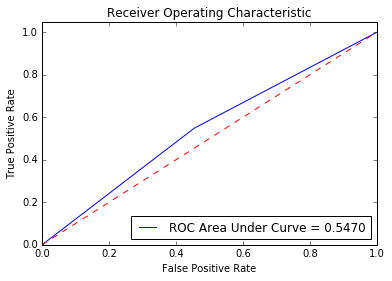




Confusion Matrix
True Pos  	| False Neg
1866 		| 1556
------------------------------
False Pos 	| True Neg
1531 		| 1862



Classification Report
             precision    recall  f1-score   support

          0       0.55      0.55      0.55      3422
          1       0.54      0.55      0.55      3393

avg / total       0.55      0.55      0.55      6815





Feature Importances:


chlorpropamide       	         0.0
repaglinide          	  0.0036485332335
payer_code           	  0.0354797657131
number_diagnoses     	  0.0314647114246
num_medications      	  0.0781685835607
rosiglitazone        	  0.0068047175354
miglitol             	         0.0
glipizide            	  0.0144631404256
discharge_disposition_id 	  0.0460749152819
citoglipton          	         0.0
admission_source_id  	  0.0168692258543
medical_specialty    	  0.0377774882314
num_lab_procedures   	  0.0971640429742
acarbose             	  0.000629657322131
diag_1               	  0.0931462394564
number_outpatient 


End:  Mon Nov 13 16:12:18 2017
(6815, 1)


In [53]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, 
                                    min_samples_split=2, min_samples_leaf=1, 
                                    min_weight_fraction_leaf=0.0, 
                                    max_features=None, random_state=13, max_leaf_nodes=None, class_weight=None, presort=False)
y_pred, y_probs = run_and_test_classifier(classifier, X_train,y_train,X_test, y_test)

df_ens = pd.DataFrame([])
df_ens['DecisionTree'] = y_probs

print np.shape(df_ens)

## Second attempt: Switch to a RF Algorithm
 


Start:  Mon Nov 13 16:12:18 2017

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Classification Results


SCORE: ROC AUC 
0.640536141811




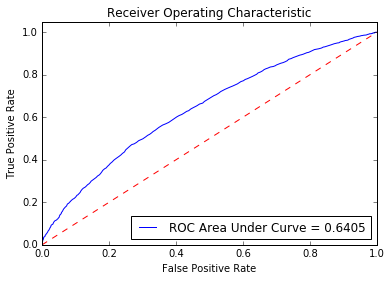




Confusion Matrix
True Pos  	| False Neg
2105 		| 1317
------------------------------
False Pos 	| True Neg
1415 		| 1978



Classification Report
             precision    recall  f1-score   support

          0       0.60      0.62      0.61      3422
          1       0.60      0.58      0.59      3393

avg / total       0.60      0.60      0.60      6815





Feature Importances:


chlorpropamide       	  0.000331585074434
repaglinide          	  0.00464435533403
payer_code           	  0.0423216108984
number_diagnoses     	  0.0426327345911
num_medications      	  0.0583194226759
rosiglitazone        	  0.0103168134552
miglitol             	  0.000205371732853
glipizide            	  0.0161693888854
discharge_disposition_id 	  0.0469220055793
citoglipton          	         0.0
admission_source_id  	  0.0299437721546
medical_specialty    	  0.0434075407578
num_lab_procedures   	  0.0588282899133
acarbose             	  0.00110142795953
diag_1               	  0.0583821395222
numb


End:  Mon Nov 13 16:12:23 2017
(6815, 2)


In [54]:
classifier = ExtraTreesClassifier(n_estimators=500, max_features='auto', n_jobs=-1)
y_pred, y_probs = run_and_test_classifier(classifier, X_train,y_train,X_test, y_test)

df_ens['ExtraTrees1'] = y_probs
print np.shape(df_ens)





## Remove the weakest columns.  This allows the remaining columns to do a better job  





In [55]:
#remove weak predictors

weak = ['pioglitazone','metformin','glyburide','glipizide','rosiglitazone','diabetesMed','max_glu_serum','glyburide-metformin','glimepiride','repaglinide','nateglinide','troglitazone','acarbose','miglitol','chlorpropamide','citoglipton','tolbutamide','metformin-rosiglitazone','metformin-pioglitazone' ,'acetohexamide', 'glimepiride-pioglitazone',
    'examide', 'tolazamide', 'glipizide-metformin']

print 'Before: ',df_train.columns.values
keep_cols = list(set(X_train.columns) - set(weak))
#print keep_cols

X_train2 = X_train[keep_cols]
X_test2 = X_test[keep_cols]
print 'After: ',X_train2.columns.values



Before:  ['chlorpropamide' 'repaglinide' 'payer_code' 'number_diagnoses'
 'num_medications' 'readmitted' 'rosiglitazone' 'miglitol' 'glipizide'
 'discharge_disposition_id' 'citoglipton' 'admission_source_id'
 'medical_specialty' 'num_lab_procedures' 'acarbose' 'diag_1'
 'number_outpatient' 'glyburide' 'metformin' 'A1Cresult' 'pioglitazone'
 'time_in_hospital' 'glyburide-metformin' 'tolbutamide' 'glimepiride'
 'troglitazone' 'metformin-rosiglitazone' 'max_glu_serum' 'diabetesMed'
 'metformin-pioglitazone' 'number_inpatient' 'number_emergency'
 'acetohexamide' 'change' 'glimepiride-pioglitazone' 'age' 'examide'
 'nateglinide' 'tolazamide' 'race' 'glipizide-metformin' 'insulin' 'gender'
 'num_procedures' 'diag_2' 'diag_3' 'admission_type_id']
After:  ['admission_type_id' 'payer_code' 'number_diagnoses' 'num_medications'
 'admission_source_id' 'num_lab_procedures' 'A1Cresult' 'time_in_hospital'
 'number_inpatient' 'discharge_disposition_id' 'change' 'gender' 'age'
 'medical_specialty' 'rac

# Let's rerun to see where we stand


Start:  Mon Nov 13 16:12:23 2017

ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='entropy',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)
Classification Results


SCORE: ROC AUC 
0.649530662968




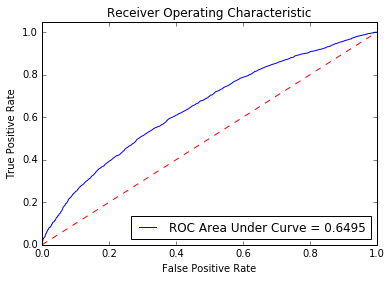




Confusion Matrix
True Pos  	| False Neg
2122 		| 1300
------------------------------
False Pos 	| True Neg
1377 		| 2016



Classification Report
             precision    recall  f1-score   support

          0       0.61      0.62      0.61      3422
          1       0.61      0.59      0.60      3393

avg / total       0.61      0.61      0.61      6815





Feature Importances:


admission_type_id    	  0.0381779106198
payer_code           	  0.0473706808463
number_diagnoses     	  0.047269608233
num_medications      	  0.064613280275
admission_source_id  	  0.0345855481105
num_lab_procedures   	  0.0645500173762
A1Cresult            	  0.0261648552948
time_in_hospital     	  0.0584080702662
number_inpatient     	  0.0562854605808
discharge_disposition_id 	  0.0498067437488
change               	  0.0158661389533
gender               	  0.0270434710957
age                  	  0.0561694165968
medical_specialty    	  0.049075938379
race                 	  0.0338249919048
number_o


End:  Mon Nov 13 16:12:34 2017
(6815, 3)


In [56]:
classifier = ExtraTreesClassifier(n_estimators=1000, max_features='auto', n_jobs=-1,  
                                  criterion='entropy',bootstrap=True, oob_score=True)
y_pred, y_probs = run_and_test_classifier(classifier, X_train2,y_train,X_test2, y_test)

df_ens['ExtraTrees2'] = y_probs
print np.shape(df_ens)

In [57]:
X_test2.head(10)

,admission_type_id,payer_code,number_diagnoses,num_medications,admission_source_id,num_lab_procedures,A1Cresult,time_in_hospital,number_inpatient,discharge_disposition_id,...,age,medical_specialty,race,number_outpatient,insulin,number_emergency,num_procedures,diag_2,diag_3,diag_1
70355,0,16,8,14,6,48,1,2,0,0,...,7,0,3,0,3,0,0,202,591,208
71086,1,8,9,22,6,74,2,6,5,0,...,8,7,3,1,1,1,0,33,58,448
93295,0,9,9,14,6,30,2,6,1,0,...,4,0,1,0,1,3,0,85,158,110
4572,0,0,7,9,6,59,2,3,3,5,...,7,17,3,0,2,0,0,200,194,215
18532,0,0,9,26,6,73,2,8,2,17,...,6,0,4,0,1,0,5,203,253,201
84888,0,1,4,15,6,64,2,4,1,0,...,6,0,3,0,1,0,0,181,100,74
100818,2,0,9,17,0,30,2,3,2,0,...,6,0,3,0,3,0,0,12,424,122
511,0,0,6,36,3,78,2,7,0,0,...,7,0,3,0,2,0,3,188,192,204
94624,0,8,8,17,6,42,1,6,6,0,...,5,0,3,0,2,5,0,398,104,70
5018,0,0,9,25,6,63,2,11,8,5,...,4,0,1,0,3,1,2,183,265,324


In [58]:
def intersect(a, b):
    return list(set(a) & set(b))
def union(a, b):
    return list(set(a) | set(b))
def subtract(a, b):
    return list(set(a) - set(b))

# Now let's go to One-Hot Encoding to try other algorithms

In [59]:
# separate the categorical from non-categorical

categoricals2 = intersect(X_train2.columns, categoricals)
non_categoricals = subtract(X_train2.columns, categoricals)

print categoricals2
print non_categoricals

['gender', 'age', 'A1Cresult', 'admission_source_id', 'medical_specialty', 'payer_code', 'race', 'diag_2', 'insulin', 'diag_1', 'discharge_disposition_id', 'diag_3', 'change', 'admission_type_id']
['number_emergency', 'time_in_hospital', 'number_diagnoses', 'num_lab_procedures', 'number_outpatient', 'num_medications', 'number_inpatient', 'num_procedures']


# If they are numerical (non-catigorical) use Standard Scaler
# if they are categorical, use On-Hot Encoding
# Then combine all columns back together

In [60]:
# Split out categoricals and numeric columns and handle separately

X_train3_cat = X_train2[categoricals2] 
X_test3_cat = X_test2[categoricals2] 
X_train3_num = X_train2[non_categoricals] 
X_test3_num = X_test2[non_categoricals] 


# Scale without categoricals
scaler = preprocessing.StandardScaler() 
scaler.fit(X_train3_num)
X_train3_num = scaler.transform(X_train3_num)
X_test3_num = scaler.transform(X_test3_num)

encoder =  preprocessing.OneHotEncoder( categorical_features='all', sparse=False)

# TODO: I dont like this it needs the test data for encoding due to unknown values
X_all_cat = pd.concat([X_train3_cat, X_test3_cat])
encoder.fit(X_all_cat)
X_train3_cat = encoder.transform(X_train3_cat)
X_test3_cat = encoder.transform(X_test3_cat)


# recombine categorical and numeric columns into one big numpy array
X_train3 = np.concatenate((X_train3_num, X_train3_cat), axis = 1 )
X_test3 = np.concatenate((X_test3_num, X_test3_cat), axis = 1 )


print np.shape(X_train3)
print X_train3
print np.shape(X_test3)
print X_test3

(15899, 1841)
[[-0.20440771 -0.51805374 -1.35214373 ...,  0.          0.          0.        ]
 [-0.20440771  2.13889347 -0.28204576 ...,  0.          0.          0.        ]
 [-0.20440771  0.14618307 -0.81709474 ...,  0.          0.          0.        ]
 ..., 
 [-0.20440771 -0.18593533  0.78805221 ...,  0.          0.          0.        ]
 [-0.20440771 -0.85017214 -1.35214373 ...,  1.          0.          0.        ]
 [-0.20440771  1.47465667  0.78805221 ...,  0.          0.          0.        ]]
(6815, 1841)
[[-0.20440771 -0.85017214  0.25300322 ...,  0.          0.          0.        ]
 [ 0.53319513  0.47830147  0.78805221 ...,  0.          0.          0.        ]
 [ 2.00840081  0.47830147  0.78805221 ...,  0.          0.          0.        ]
 ..., 
 [ 2.74600365  1.14253827  0.78805221 ...,  0.          0.          0.        ]
 [-0.20440771 -1.18229054 -0.28204576 ...,  0.          0.          0.        ]
 [-0.20440771  1.47465667  0.78805221 ...,  0.          0.          0.        

# Let's try again, this time using Ensemble Learning

1. Train a number of different algorithms on the same data, or variations of the same data
1. Run predictions for each trained model
1. Average the results of all the different algorithms 
1. Use the averages as the new predictions.
1. Determine accuracy of the ensemble.


Start:  Mon Nov 13 16:12:34 2017

ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='entropy',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)
Classification Results


SCORE: ROC AUC 
0.665784991033




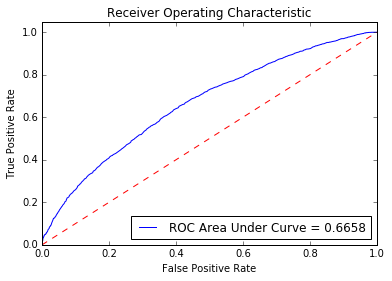




Confusion Matrix
True Pos  	| False Neg
2090 		| 1332
------------------------------
False Pos 	| True Neg
1265 		| 2128



Classification Report
             precision    recall  f1-score   support

          0       0.62      0.61      0.62      3422
          1       0.62      0.63      0.62      3393

avg / total       0.62      0.62      0.62      6815





Feature Importances:



End:  Mon Nov 13 16:13:20 2017
(6815, 4)


In [61]:
classifier = ExtraTreesClassifier(n_estimators=1000, max_features='auto', n_jobs=-1,  
                                  criterion='entropy',bootstrap=True, oob_score=True)
y_pred, y_probs = run_and_test_classifier(classifier, X_train3,y_train,X_test3, y_test)

df_ens['ExtraTrees3'] = y_probs
print np.shape(df_ens)

In [62]:
print np.shape(df_ens)

(6815, 4)



Start:  Mon Nov 13 16:13:20 2017

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=1e-06,
          verbose=0, warm_start=False)
Classification Results


SCORE: ROC AUC 
0.656125660439




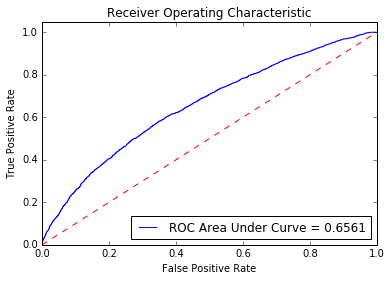




Confusion Matrix
True Pos  	| False Neg
2182 		| 1240
------------------------------
False Pos 	| True Neg
1391 		| 2002



Classification Report
             precision    recall  f1-score   support

          0       0.61      0.64      0.62      3422
          1       0.62      0.59      0.60      3393

avg / total       0.61      0.61      0.61      6815





Feature Importances:



End:  Mon Nov 13 16:13:29 2017
(6815, 5)


In [63]:
from  sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(  penalty='l1', 
                                  dual=False, 
                                  tol=0.000001, C=1.0, 
                                  fit_intercept=True, 
                                  intercept_scaling=1, 
                                  class_weight=None, 
                                  random_state=None, 
                                  solver='liblinear', 
                                  max_iter=1000, 
                                  multi_class='ovr', 
                                  verbose=0, 
                                  warm_start=False, 
                                  n_jobs=-1)
y_pred, y_probs = run_and_test_classifier(classifier, X_train3,y_train,X_test3, y_test)

df_ens['Logistic'] = y_probs
print np.shape(df_ens)


Start:  Mon Nov 13 16:13:29 2017

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=1000, n_iter=None,
       n_jobs=-1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=1e-06, verbose=0, warm_start=False)
Classification Results


SCORE: ROC AUC 
0.636753428648




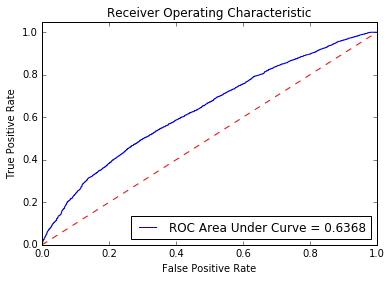




Confusion Matrix
True Pos  	| False Neg
2395 		| 1027
------------------------------
False Pos 	| True Neg
1703 		| 1690



Classification Report
             precision    recall  f1-score   support

          0       0.58      0.70      0.64      3422
          1       0.62      0.50      0.55      3393

avg / total       0.60      0.60      0.60      6815





Feature Importances:



End:  Mon Nov 13 16:13:35 2017
(6815, 6)


In [64]:
from  sklearn.linear_model import SGDClassifier

classifier = SGDClassifier(loss='log', 
                           penalty='elasticnet', 
                           alpha=0.0001, 
                           l1_ratio=0.15, 
                           fit_intercept=True, 
                           max_iter=1000, 
                           tol = 0.000001,
                           shuffle=True, 
                           verbose=0, 
                           epsilon=0.1, 
                           n_jobs=-1, 
                           random_state=None, 
                           learning_rate='optimal', 
                           eta0=0.0, 
                           power_t=0.5, 
                           class_weight=None, 
                           warm_start=False, 
                           average=False)
y_pred, y_probs = run_and_test_classifier(classifier, X_train3,y_train,X_test3, y_test)

df_ens['SGD'] = y_probs
print np.shape(df_ens)

In [65]:
print 1

1



Start:  Mon Nov 13 16:13:35 2017

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.9, n_estimators=300, random_state=None)
Classification Results


SCORE: ROC AUC 
0.668452324663




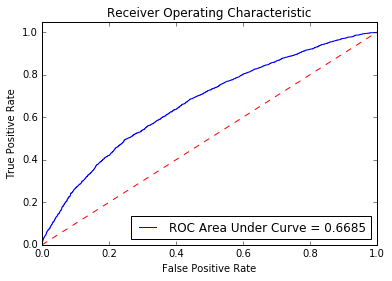




Confusion Matrix
True Pos  	| False Neg
2275 		| 1147
------------------------------
False Pos 	| True Neg
1441 		| 1952



Classification Report
             precision    recall  f1-score   support

          0       0.61      0.66      0.64      3422
          1       0.63      0.58      0.60      3393

avg / total       0.62      0.62      0.62      6815





Feature Importances:


admission_type_id    	  0.00666666666667
payer_code           	  0.0233333333333
number_diagnoses     	        0.03
num_medications      	  0.0533333333333
admission_source_id  	  0.0233333333333
num_lab_procedures   	        0.07
A1Cresult            	  0.00666666666667
time_in_hospital     	  0.0266666666667
number_inpatient     	        0.04
discharge_disposition_id 	  0.256666666667
change               	         0.0
gender               	         0.0
age                  	        0.02
medical_specialty    	  0.0366666666667
race                 	  0.00333333333333
number_outpatient    	  0.0233333


End:  Mon Nov 13 16:13:42 2017
(6815, 7)


In [66]:
# Using Dense not oneHotEncoded X_train2 with AdaBoostClassifier

from sklearn.ensemble import AdaBoostClassifier
classifier = AdaBoostClassifier(n_estimators=300, learning_rate=0.9)
y_pred, y_probs = run_and_test_classifier(classifier, X_train2,y_train,X_test2, y_test)

df_ens['AdaBoost'] = y_probs
print np.shape(df_ens)


In [67]:
print df_ens.head(12)

    DecisionTree  ExtraTrees1  ExtraTrees2  ExtraTrees3  Logistic       SGD  \
0            0.0        0.472        0.428        0.419  0.415128  0.297203   
1            1.0        0.636        0.687        0.552  0.688404  0.515044   
2            1.0        0.582        0.616        0.490  0.370754  0.297493   
3            1.0        0.576        0.553        0.648  0.782301  0.672043   
4            0.0        0.632        0.622        0.507  0.549424  0.509042   
5            1.0        0.610        0.479        0.354  0.220394  0.158647   
6            1.0        0.638        0.639        0.519  0.595808  0.602216   
7            0.0        0.474        0.399        0.371  0.354331  0.396561   
8            1.0        0.744        0.740        0.604  0.629785  0.329846   
9            1.0        0.808        0.814        0.677  0.941979  0.911107   
10           0.0        0.218        0.249        0.325  0.400504  0.424048   
11           0.0        0.458        0.417        0.

In [68]:
print df_ens['AdaBoost'].head(50)

0     0.499553
1     0.501211
2     0.500227
3     0.500773
4     0.500537
5     0.499600
6     0.500761
7     0.499764
8     0.501104
9     0.502200
10    0.499403
11    0.499485
12    0.500005
13    0.499507
14    0.499666
15    0.500809
16    0.499190
17    0.500673
18    0.512973
19    0.499817
20    0.500735
21    0.499443
22    0.500119
23    0.499882
24    0.500494
25    0.500584
26    0.499518
27    0.500081
28    0.500132
29    0.500513
30    0.499760
31    0.499986
32    0.498875
33    0.499554
34    0.499951
35    0.500236
36    0.499988
37    0.499896
38    0.499764
39    0.500033
40    0.529832
41    0.500060
42    0.499778
43    0.499950
44    0.500226
45    0.500589
46    0.499614
47    0.499699
48    0.500394
49    0.499377
Name: AdaBoost, dtype: float64


Overall AUC:  0.671565189996


ExtraTrees1                    	0.640536141811
ExtraTrees2                    	0.649530662968
ExtraTrees3                    	0.665784991033
Logistic                       	0.656125660439
AdaBoost                       	0.668452324663
SCORE: ROC AUC 
0.671565189996




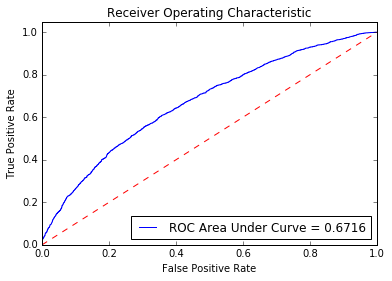

In [70]:

if 'DecisionTree' in df_ens.columns:
    del df_ens['DecisionTree']

if 'SGD' in df_ens.columns:
    del df_ens['SGD']

ens = df_ens.mean(axis=1)

print 'Overall AUC: ', metrics.roc_auc_score(y_test, ens.values)
print
print
for c in df_ens.columns:
    p = (df_ens[c]).values
    print c.ljust(30), '\t',metrics.roc_auc_score(y_test, p)
    


plot_roc(y_test, ens.values)